# Modeling Dynamic Social Networks

## 1. Introduction: The Complexity of Temporal Social Systems

The analysis of social media dynamics has evolved from static graph theory—where relationships are treated as permanent, structural bridges—to temporal network analysis, where interactions are viewed as transient, stochastic events. This notebook implements a strategy to model a dynamic social network derived from Reddit user interactions. Reddit is defined by interactional events (replies) rather than declared relationships. These events are directional, ephemeral, and structurally distinct, often forming "reply trees".

The strategy articulates a **Markovian user lifecycle model** with a **Generative Network Model** (specifically an extended Barabási-Albert algorithm). This aligns with the state-of-the-art approach known as **decoupled dynamic graph modeling**, separating the "physics" of the population (who is present?) from the "geometry" of the interaction (who talks to whom?).

### 1.1 The Nature of the Data: Interaction vs. Relation

We define a link $u \to v$ if user $u$ replies to user $v$ within a one-month timeframe. This transforms the continuous stream of timestamped events into a sequence of **Discrete-Time Dynamic Graphs (DTDGs)**, denoted as $\mathcal{G} = \{G_1, G_2, \dots, G_T\}$.

This definition carries specific topological implications:
*   **Forest of Trees Topology**: Reddit threads are arborescent. A root node (OP) attracts primary replies, which attract secondary replies.
*   **The Reciprocity Imperative**: In a directed social graph, reciprocity ($v$ replies to $u$ after $u$ replies to $v$) is a critical signature of social engagement.
*   **High Volatility (Churn)**: Unlike citation networks, Reddit users churn. A significant portion of nodes in $G_t$ will be absent in $G_{t+1}$.

---
**Implementation Step 0: Setup and Data Loading**
First, we load the necessary libraries and the preprocessed network snapshots.

In [ ]:
from collections import Counter

import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import display, Image
from pathlib import Path
from scipy import stats
from scipy.spatial.distance import jensenshannon

import src.visualizations as viz

# Load the network snapshots
# Adjust years and months as per your dataset availability
# Note: Ensure you are running this from the 'code' directory so the relative path in load_network_snapshots works,
# or adjust the 'dir' parameter if needed.
snapshots = viz.load_network_snapshots(years=range(2015, 2019), months=(1, 4, 7, 10), directed=True)

# Sort keys to ensure chronological order for the estimator
sorted_keys = sorted(snapshots.keys(), key=lambda x: (int(x.split('#')[0]), int(x.split('#')[1])))
print(f"Loaded {len(snapshots)} snapshots.")
print("Chronological order:", sorted_keys)

Snapshot file not found for period 2015#1 (../data/02_preprocessed/user_network_month_2015#1.pkl)
Successfully loaded snapshot for period 2015#4
Successfully loaded snapshot for period 2015#7
Successfully loaded snapshot for period 2015#10
Successfully loaded snapshot for period 2016#1
Successfully loaded snapshot for period 2016#4
Successfully loaded snapshot for period 2016#7
Successfully loaded snapshot for period 2016#10
Successfully loaded snapshot for period 2017#1
Successfully loaded snapshot for period 2017#4
Successfully loaded snapshot for period 2017#7
Successfully loaded snapshot for period 2017#10
Successfully loaded snapshot for period 2018#1
Successfully loaded snapshot for period 2018#4
Successfully loaded snapshot for period 2018#7
Successfully loaded snapshot for period 2017#1
Successfully loaded snapshot for period 2017#4
Successfully loaded snapshot for period 2017#7
Successfully loaded snapshot for period 2017#10
Successfully loaded snapshot for period 2018#1
Succe

## 2. Theoretical Framework: The Markovian Lifecycle Model

The first component is the Markov model describing network growth and user turnover. It serves as the **Macroscopic Controller**, determining the boundary conditions for the generative model at each time step.

### 2.1 Defining the User State Space
A binary "Active/Inactive" state space is insufficient. We define a Multi-State Lifecycle Model:
*   **New ($N$)**: Users appearing for the absolute first time.
*   **Active ($A$)**: Users present in $G_t$ who were also present in $G_{t-1}$.
*   **Dormant ($D$)**: Users who were active in the past but have zero degree in $G_t$.

### 2.2 Mathematical Derivation of Transition Probabilities
The core is the **Transition Probability Matrix $\mathbf{P}_t$**, where $p_{ij}(t)$ is the probability of moving from state $i$ to $j$.

$$
\mathbf{P}_t = \begin{bmatrix}
P_{NN} & P_{NA} & P_{ND} \\
P_{AN} & P_{AA} & P_{AD} \\
P_{DN} & P_{DA} & P_{DD} 
\end{bmatrix}
$$

*   **Impossible Transitions**: $P_{AN} = 0$ and $P_{DN} = 0$. Existing users cannot become "New".
*   **The Influx Vector**: The number of new users $n_N(t+1)$ is determined by an exogenous birth process vector $\mathbf{b}(t)$.

The population evolution is modeled as:
$$ \mathbf{n}_{t+1} = \mathbf{n}_t \mathbf{P} + \mathbf{b}_{t+1} $$

### 2.3 Estimation Strategy
We calculate a sequence of matrices from the snapshots to capture non-stationarity. The function below implements this estimation, tracking user histories to calculate $P(Next | Current)$ and birth rates.

In [22]:
def estimate_simulation_parameters(network_snapshots):
    """
    Learns Markov transition probabilities and generative parameters
    from your real data snapshots.

    Args:
        network_snapshots: dict {key: G_t, ...} where G_t is a nx.DiGraph

    Returns:
        params: dict containing transition matrix P, birth rates, reciprocity, etc.
    """
    # Sort indices based on the YYYY#M format
    sorted_indices = sorted(network_snapshots.keys(), key=lambda x: (int(x.split('#')[0]), int(x.split('#')[1])))

    # --- 1. Global Sets for Tracking History ---
    all_seen_users = set()
    transitions = []
    birth_counts = []

    # Metrics to average over time
    reciprocity_scores = []
    out_degree_avgs = []

    # We need to track the state of every user at the END of step t-1
    # States: 'New', 'Active', 'Dormant'
    # Initialize with the first snapshot
    t0 = sorted_indices[0]
    current_users = set(network_snapshots[t0].nodes())
    all_seen_users.update(current_users)

    # Track who was active in the LAST processed snapshot
    last_active_set = current_users

    # --- 2. Iterate Through Time Steps ---
    for t in sorted_indices[1:]:
        G_t = network_snapshots[t]
        current_users = set(G_t.nodes())

        # Identify New Users (Births)
        new_users = current_users - all_seen_users
        birth_counts.append(len(new_users))
        all_seen_users.update(new_users)

        # Identify Dormant Pool (Anyone seen before who was NOT active last step)
        # Note: In step t, the "Dormant Pool" is anyone seen before t, excluding those active at t-1
        dormant_pool = (all_seen_users - last_active_set) - new_users

        # --- Calculate Transitions ---

        # A ->? (From Active at t-1)
        for user in last_active_set:
            if user in current_users:
                transitions.append(('Active', 'Active'))
            else:
                transitions.append(('Active', 'Dormant'))

        # D ->? (From Dormant pool)
        for user in dormant_pool:
            if user in current_users:
                transitions.append(('Dormant', 'Active')) # Resurrection
            else:
                transitions.append(('Dormant', 'Dormant'))

        # --- Calculate Generative Topology Metrics ---
        # 1. Reciprocity (Argument factor)
        recip = nx.reciprocity(G_t)
        reciprocity_scores.append(recip)

        # 2. Average Out-Degree (Edges / Nodes)
        # This controls the volume of edges generated per active user
        if G_t.number_of_nodes() > 0:
            avg_out = G_t.number_of_edges() / G_t.number_of_nodes()
            out_degree_avgs.append(avg_out)

        # Update last_active for next loop
        last_active_set = current_users

    # --- 3. Compile Transition Matrix P ---
    trans_counts = Counter(transitions)
    P = {}

    # Calculate probabilities: P(Next | Current) = Count(Current->Next) / Count(Current)
    for start_state in ['Active', 'Dormant']:
        total = sum([cnt for (s, e), cnt in trans_counts.items() if s == start_state])
        if total == 0: continue

        for end_state in ['Active', 'Dormant']:
            count = trans_counts.get((start_state, end_state), 0)
            P[(start_state, end_state)] = count / total

    # Default fallback if data is missing specific transitions
    defaults = {
        ('Active', 'Active'): 0.5, ('Active', 'Dormant'): 0.5,
        ('Dormant', 'Active'): 0.05, ('Dormant', 'Dormant'): 0.95
    }
    for k, v in defaults.items():
        if k not in P: P[k] = v

    return {
        "P": P,
        "birth_rates": birth_counts,
        "avg_reciprocity": np.mean(reciprocity_scores) if reciprocity_scores else 0,
        "avg_out_degree": np.mean(out_degree_avgs) if out_degree_avgs else 2.5,
        "activity_exponent": 2.5 # Standard for social media
    }

### 3. Visualizing the Learned Markov Model

To better understand the dynamics captured by the estimator, we visualize the transition probabilities between user states. This diagram shows the flow of users between **Active** and **Dormant** states, as well as the influx of **New** users.

✓ Diagram saved to ´../data/04_reports/evolution_sims/reddit_lifecycle.png'


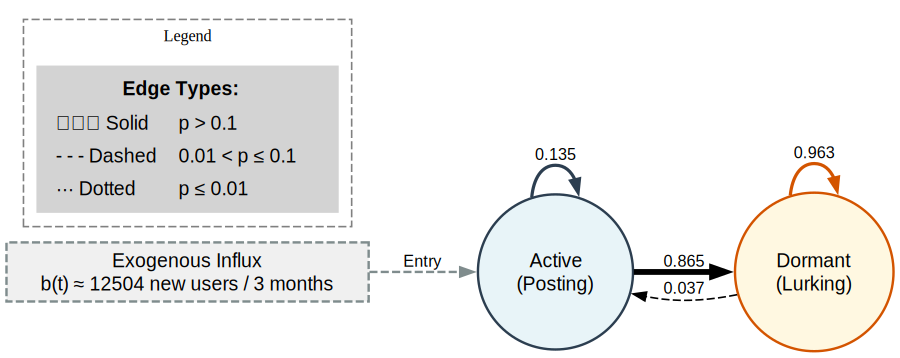

In [23]:
# Create image directory if it doesn't exist
IMAGE_DIR = Path("../data/04_reports/evolution_sims/")
IMAGE_DIR.mkdir(parents=True, exist_ok=True)

def visualize_reddit_markov_chain(params, filename='reddit_lifecycle'):
    """
    Visualizes the Markov transition matrix for the Reddit User Lifecycle.
    Produces a publication-quality diagram.
    """
    file_path = IMAGE_DIR / (filename + ".png")
    P = params['P']
    birth_rates = params.get('birth_rates', [])
    avg_birth_rate = sum(birth_rates) / len(birth_rates) if birth_rates else 0

    def format_prob(prob, threshold=1e-3):
        if prob < threshold: return f'{prob:.2e}'
        else: return f'{prob:.3f}'

    # Create graph with moderate size and DPI for notebook display
    dot = graphviz.Digraph(comment='Reddit User Lifecycle Markov Chain')
    dot.attr(rankdir='LR', size='6,4', dpi='150', bgcolor='white')

    # Global node/edge styles for academic look
    dot.attr('node', shape='circle', style='filled',
             fontname='Helvetica', fontsize='12', penwidth='1.5')
    dot.attr('edge', fontname='Helvetica', fontsize='10', arrowsize='0.8')

    # Academic Color Palette (Muted/Professional)
    colors = {
        'Active': '#E8F4F8',   # Very Light Blue
        'Dormant': '#FFF8E1',  # Very Light Gold/Cream
        'New': '#F0F0F0'       # Light Gray
    }
    border_colors = {
        'Active': '#2C3E50',
        'Dormant': '#D35400',
        'New': '#7F8C8D'
    }

    # 1. Nodes
    # New User Source (Exogenous)
    # Simplified label to avoid LaTeX rendering issues in standard Graphviz
    label_new = f"Exogenous Influx\nb(t) ≈ {int(avg_birth_rate)} new users / 3 months"
    dot.node('New', label_new, shape='box', style='dashed,filled',
             fillcolor=colors['New'], color=border_colors['New'],
             width='1.2')

    # Active State
    dot.node('Active', 'Active\n(Posting)',
             fillcolor=colors['Active'], color=border_colors['Active'])

    # Dormant State
    dot.node('Dormant', 'Dormant\n(Lurking)',
             fillcolor=colors['Dormant'], color=border_colors['Dormant'])

    # 2. Edges

    # New -> Active (Deterministic Influx)
    dot.edge('New', 'Active', label=' Entry ',
             color=border_colors['New'], style='dashed', penwidth='1.5')

    # Transitions from P
    states = ['Active', 'Dormant']
    for source in states:
        for target in states:
            prob = P.get((source, target), 0.0)

            if prob > 0:
                label = format_prob(prob)

                # Style logic based on probability magnitude
                style = 'solid'
                weight = '1.0'

                if source == target: # Self-loops
                    weight = '2.0'
                    edge_color = border_colors[source]
                else: # Transitions
                    edge_color = 'black'
                    if prob > 0.1:
                        style = 'solid'
                        weight = str(1.0 + prob * 3)
                    elif prob > 0.01:
                        style = 'dashed'
                        weight = '1.0'
                    else:
                        style = 'dotted'
                        weight = '0.5'

                dot.edge(source, target, label=label,
                         color=edge_color, style=style, penwidth=weight)

    # 3. Legend
    with dot.subgraph(name='cluster_legend') as legend:
        legend.attr(label='Legend', fontsize='10', style='dashed', color='gray')
        legend_table = '<<TABLE BORDER="0" CELLBORDER="0" CELLSPACING="2">'
        legend_table += '<TR><TD COLSPAN="2"><B>Edge Types:</B></TD></TR>'
        legend_table += '<TR><TD ALIGN="LEFT">━━━ Solid</TD><TD ALIGN="LEFT">p &gt; 0.1</TD></TR>'
        legend_table += '<TR><TD ALIGN="LEFT">- - - Dashed</TD><TD ALIGN="LEFT">0.01 &lt; p ≤ 0.1</TD></TR>'
        legend_table += '<TR><TD ALIGN="LEFT">··· Dotted</TD><TD ALIGN="LEFT">p ≤ 0.01</TD></TR>'
        legend_table += '</TABLE>>'
        legend.node('legend_node', legend_table, shape='plaintext')

    # Render
    try:
        # Save but do not display explicitly to avoid duplication if returning dot
        dot.render(file_path, format='png', cleanup=True)
        print(f"✓ Diagram saved to ´../data/04_reports/evolution_sims/{filename}.png'")
    except Exception as e:
        print(f"✗ Error rendering diagram: {e}")

    return dot

# Call the visualization
visualize_reddit_markov_chain(params)

## 4. Theoretical Framework: The Generative Network Model

The second pillar is the Generative Model. It receives the population list from the Markov model and "wires" them together.

### 4.1 Critique of the Standard Barabási-Albert (BA) Model
Standard BA is ill-suited for Reddit because:
1.  **Undirectedness**: BA generates undirected edges, conflating "replying" with "being replied to".
2.  **No Node Deletion**: BA assumes infinite growth. With churn, high-degree nodes would never leave ("The Methuselah Effect").
3.  **Linearity**: Attachment in online media is often super-linear or sub-linear.

### 4.2 Extension 1: Directed Preferential Attachment (Price’s Model)
We use **Price’s Model (1976)**, designed for citation networks. The probability that a new node $u$ connects to $v$ depends on $v$'s in-degree ($k_{in}$):

$$ \Pi(v \leftarrow u) = \frac{k_{in}(v) + A}{\sum_j (k_{in}(j) + A)} $$

$A$ is the "initial attractiveness," allowing nodes with zero degree to attract edges.

### 4.3 Extension 2: Node Fitness (The Bianconi-Barabási Mechanism)
To model "virality," we integrate the **Bianconi-Barabási (BB) Model**, assigning a fitness parameter $\eta_v$ to each node.

$$ \Pi(v \leftarrow u) = \frac{\eta_v (k_{in}(v) + A)}{\sum_j \eta_j (k_{in}(j) + A)} $$

$\eta$ is drawn from a Log-Normal Distribution to model variance in content quality.

### 4.4 Extension 3: Explicit Reciprocity
Reddit allows loops ($u \to v$ then $v \to u$). We include a **Reciprocity Module**: when $u \to v$ is created, we perform a Bernoulli trial with probability $p_{recip}$ to add $v \to u$.

### 4.5 Implementation: The Hybrid Simulator
The `RedditNetworkSimulator` class below implements this **Price + Fitness + Activity** model. It separates "who talks" (Activity kernel) from "who is listened to" (Fitness/Popularity kernel) and enforces the churn dynamics.

In [24]:
# ...existing code...
class RedditNetworkSimulator:
    def __init__(self, initial_snapshot, params):
        """
        initial_snapshot: nx.DiGraph (Your starting point, e.g., 2015-01)
        params: The dict returned by estimate_simulation_parameters
        """
        self.P = params['P']
        self.birth_rates = params['birth_rates']
        self.reciprocity = params['avg_reciprocity']

        # Simulation State
        self.current_step = 0
        self.active_users = list(initial_snapshot.nodes())
        self.dormant_users = []

        # --- PERSISTENT MEMORY ---
        # Cumulative In-Degree: Represents "Reputation".
        # It accumulates over time and never resets, even if user goes dormant.

        # FIX: Handle undirected graphs (nx.Graph) which don't have in_degree
        if initial_snapshot.is_directed():
            self.cumulative_in_degree = dict(initial_snapshot.in_degree())
        else:
            # For undirected graphs, use degree as a proxy for initial reputation
            self.cumulative_in_degree = dict(initial_snapshot.degree())

        # --- LATENT TRAITS ---
        # Assign hidden traits to initial users
        self.node_traits = {}
        for n in self.active_users:
            self._init_node_traits(n)

    def _init_node_traits(self, node_id):
        """
        Assigns 'Activity' (how much they post) and 'Fitness' (how good their posts are).
        """
        # Activity: Power-law (Most users post little, few post a lot)
        # Using Pareto distribution (alpha=2.5 is typical for social media)
        activity = (np.random.pareto(2.5) + 1)

        # Fitness: Log-Normal (Multiplicative quality processes)
        # Represents the "virality potential" of the user
        fitness = np.random.lognormal(mean=0, sigma=0.5)

        self.node_traits[node_id] = {'activity': activity, 'fitness': fitness}

        # Ensure they exist in cumulative counter
        if node_id not in self.cumulative_in_degree:
            self.cumulative_in_degree[node_id] = 0

    def step(self):
        """
        Advances the simulation by one timestamp (3 months).
        Returns: nx.DiGraph (The snapshot for this timestamp)
        """
        if self.current_step >= len(self.birth_rates):
            print("Simulation timeline ended.")
            return None

        # ==========================================
        # 1. MARKOV POPULATION DYNAMICS
        # ==========================================

        next_active = []
        next_dormant = [] # Start fresh for next dormant pool

        # A. Process CURRENT ACTIVE Users
        if self.active_users:
            # Vectorized Coin Toss
            p_stay = self.P.get(('Active', 'Active'), 0.5)
            # Generate random numbers for all active users at once
            decisions = np.random.random(len(self.active_users))

            # Boolean masking is faster than loops for splitting lists
            active_arr = np.array(self.active_users)
            stay_mask = decisions < p_stay

            next_active.extend(active_arr[stay_mask])
            # Those who leave become dormant
            next_dormant.extend(active_arr[~stay_mask])

        # B. Process DORMANT Users (Resurrection)
        # Note: We add previous step's dormant users to the check list
        if self.dormant_users:
            p_wake = self.P.get(('Dormant', 'Active'), 0.05)
            dormant_arr = np.array(self.dormant_users)

            decisions = np.random.random(len(dormant_arr))
            wake_mask = decisions < p_wake

            next_active.extend(dormant_arr[wake_mask])
            next_dormant.extend(dormant_arr[~wake_mask])

        # C. Process NEW Users (Birth)
        num_new = self.birth_rates[self.current_step]
        # Create unique IDs for new users based on time step
        new_nodes = [f"u_t{self.current_step}_{i}" for i in range(num_new)]

        for n in new_nodes:
            self._init_node_traits(n)
            next_active.append(n)

        # Update System State
        self.active_users = next_active
        # Update dormant pool (accumulate previous dormant + newly dormant)
        self.dormant_users = next_dormant

        # ==========================================
        # 2. GENERATIVE NETWORK MODEL (Wiring)
        # ==========================================

        # Initialize empty graph for this snapshot
        G_t = nx.DiGraph()
        G_t.add_nodes_from(self.active_users)

        n_active = len(self.active_users)
        if n_active < 2:
            self.current_step += 1
            return G_t

        active_arr = np.array(self.active_users)

        # --- Kernel 1: Source Selection (Who replies?) ---
        # Probability depends on 'activity' trait
        activities = np.array([self.node_traits[u]['activity'] for u in self.active_users])
        p_source = activities / activities.sum()

        # --- Kernel 2: Target Selection (Who gets replied to?) ---
        # Probability depends on Price's Kernel: (In-Degree + A) * Fitness
        # Use cumulative degree (Reputation)
        degrees = np.array([self.cumulative_in_degree[u] for u in self.active_users])
        fitnesses = np.array([self.node_traits[u]['fitness'] for u in self.active_users])

        A_const = 1.0 # The "free" attractiveness (allows 0-degree nodes to get replies)
        attractiveness = (degrees + A_const) * fitnesses
        p_target = attractiveness / attractiveness.sum()

        # --- Edge Generation ---
        # Determine volume of edges.
        # Heuristic: Average Reddit user makes ~2-3 replies per active session.
        # You can calibrate this multiplier from your real data (Edge Count / Node Count)
        # TUNING: Reduced multiplier from 2.5 to 1.7 to match real edge counts better
        m_edges = int(n_active * 1.7)

        # Sample Sources and Targets
        source_idxs = np.random.choice(n_active, size=m_edges, p=p_source)
        target_idxs = np.random.choice(n_active, size=m_edges, p=p_target)

        edges_to_add = []

        # Calculate corrected reciprocity probability
        # If target reciprocity is R, we need p such that p / (1+p) = R/2 approx?
        # Actually, for simple Bernoulli trial on existing edges:
        # If we add (u,v), and with prob p add (v,u).
        # Total edges = N + N*p. Mutual edges = N*p * 2.
        # Reciprocity = (2*N*p) / (N + N*p) = 2p / (1+p)
        # So R(1+p) = 2p => R + Rp = 2p => R = p(2-R) => p = R / (2-R)
        if self.reciprocity >= 2: p_recip = 1.0
        else: p_recip = self.reciprocity / (2.0 - self.reciprocity)

        for s, t in zip(source_idxs, target_idxs):
            if s != t: # No self-replies
                u, v = active_arr[s], active_arr[t]
                edges_to_add.append((u, v))

                # --- Kernel 3: Explicit Reciprocity ---
                # "Argument Loop": If u -> v, chance v -> u back instantly
                # TUNING: Use the corrected probability
                if np.random.random() < p_recip:
                    edges_to_add.append((v, u))

        G_t.add_edges_from(edges_to_add)

        # ==========================================
        # 3. UPDATE PERSISTENCE
        # ==========================================
        # Add new edges to cumulative history (for reputation in future steps)
        current_in_degrees = dict(G_t.in_degree())
        for u, deg in current_in_degrees.items():
            self.cumulative_in_degree[u] += deg

        self.current_step += 1
        return G_t

## 5. Articulating the Models: The Simulation Architecture

The simulation follows a **Master-Worker pattern**:
1.  **Master (Markov Model)**: Determines the agents (Active, Dormant, New) for the current step.
2.  **Worker (Generative Model)**: Determines their actions (wiring edges).

In [25]:
# 1. Calibrate Model
print("Estimating parameters from real data...")
params = estimate_simulation_parameters(snapshots)
print("Calibration Complete.")
print(f"Retention Rate (A->A): {params['P'].get(('Active', 'Active'), 0.5):.2f}")
print(f"Resurrection Rate (D->A): {params['P'].get(('Dormant', 'Active'), 0.05):.2f}")
print(f"Avg Reciprocity: {params['avg_reciprocity']:.2f}")

# 2. Initialize Simulator
# We start the sim using your FIRST real snapshot (e.g., 2015-01)
# Ensure we use the sorted keys to get the first one
sorted_keys = sorted(snapshots.keys(), key=lambda x: (int(x.split('#')[0]), int(x.split('#')[1])))
start_key = sorted_keys[0]
print(f"Starting simulation from snapshot: {start_key}")

sim = RedditNetworkSimulator(snapshots[start_key], params)

# 3. Run Simulation
simulated_snapshots = {}
print("\nStarting Simulation...")

# We simulate for as many steps as we have birth rate data
for t in range(len(params['birth_rates'])):
    print(f"Simulating Step {t+1}...")
    G_sim = sim.step()

    if G_sim:
        simulated_snapshots[t] = G_sim

        # Optional: Quick validation print
        print(f" -> Nodes: {G_sim.number_of_nodes()}, Edges: {G_sim.number_of_edges()}")
        # Compare Reciprocity with real target
        print(f" -> Sim Reciprocity: {nx.reciprocity(G_sim):.3f} (Target: {params['avg_reciprocity']:.3f})")

print("Simulation Finished.")

Estimating parameters from real data...
Calibration Complete.
Retention Rate (A->A): 0.14
Resurrection Rate (D->A): 0.04
Avg Reciprocity: 0.34
Starting simulation from snapshot: 2015#4

Starting Simulation...
Simulating Step 1...
 -> Nodes: 12114, Edges: 24885
 -> Sim Reciprocity: 0.346 (Target: 0.339)
Simulating Step 2...
Calibration Complete.
Retention Rate (A->A): 0.14
Resurrection Rate (D->A): 0.04
Avg Reciprocity: 0.34
Starting simulation from snapshot: 2015#4

Starting Simulation...
Simulating Step 1...
 -> Nodes: 12114, Edges: 24885
 -> Sim Reciprocity: 0.346 (Target: 0.339)
Simulating Step 2...
 -> Nodes: 12535, Edges: 25668
 -> Sim Reciprocity: 0.341 (Target: 0.339)
Simulating Step 3...
 -> Nodes: 12535, Edges: 25668
 -> Sim Reciprocity: 0.341 (Target: 0.339)
Simulating Step 3...
 -> Nodes: 15784, Edges: 32314
 -> Sim Reciprocity: 0.340 (Target: 0.339)
Simulating Step 4...
 -> Nodes: 15784, Edges: 32314
 -> Sim Reciprocity: 0.340 (Target: 0.339)
Simulating Step 4...
 -> Nodes:

### 6. Validation and Metrics
To verify the model, we compare the generated graphs $G_{sim, t}$ against empirical graphs $G_{real, t}$.
*   **Distributional Metrics**: Earth Mover's Distance (EMD) between degree distributions.
*   **Topological Metrics**: Reciprocity Coefficient and Clustering Coefficient.
*   **Temporal Metrics**: Burstiness parameters.

The execution block below runs the calibration, initializes the simulator, and generates the evolving network, printing validation metrics at each step.

Training on 12 snapshots (2015-2017ish)
Testing on 3 snapshots (2018ish)
Learned Parameters (Train Set):
 - Reciprocity: 0.338
 - Avg Out-Degree: 1.728
Running simulation...
Metrics saved to ../data/04_reports/evolution_sims/validation_metrics.csv
Plot saved to ../data/04_reports/evolution_sims/validation_plots.png


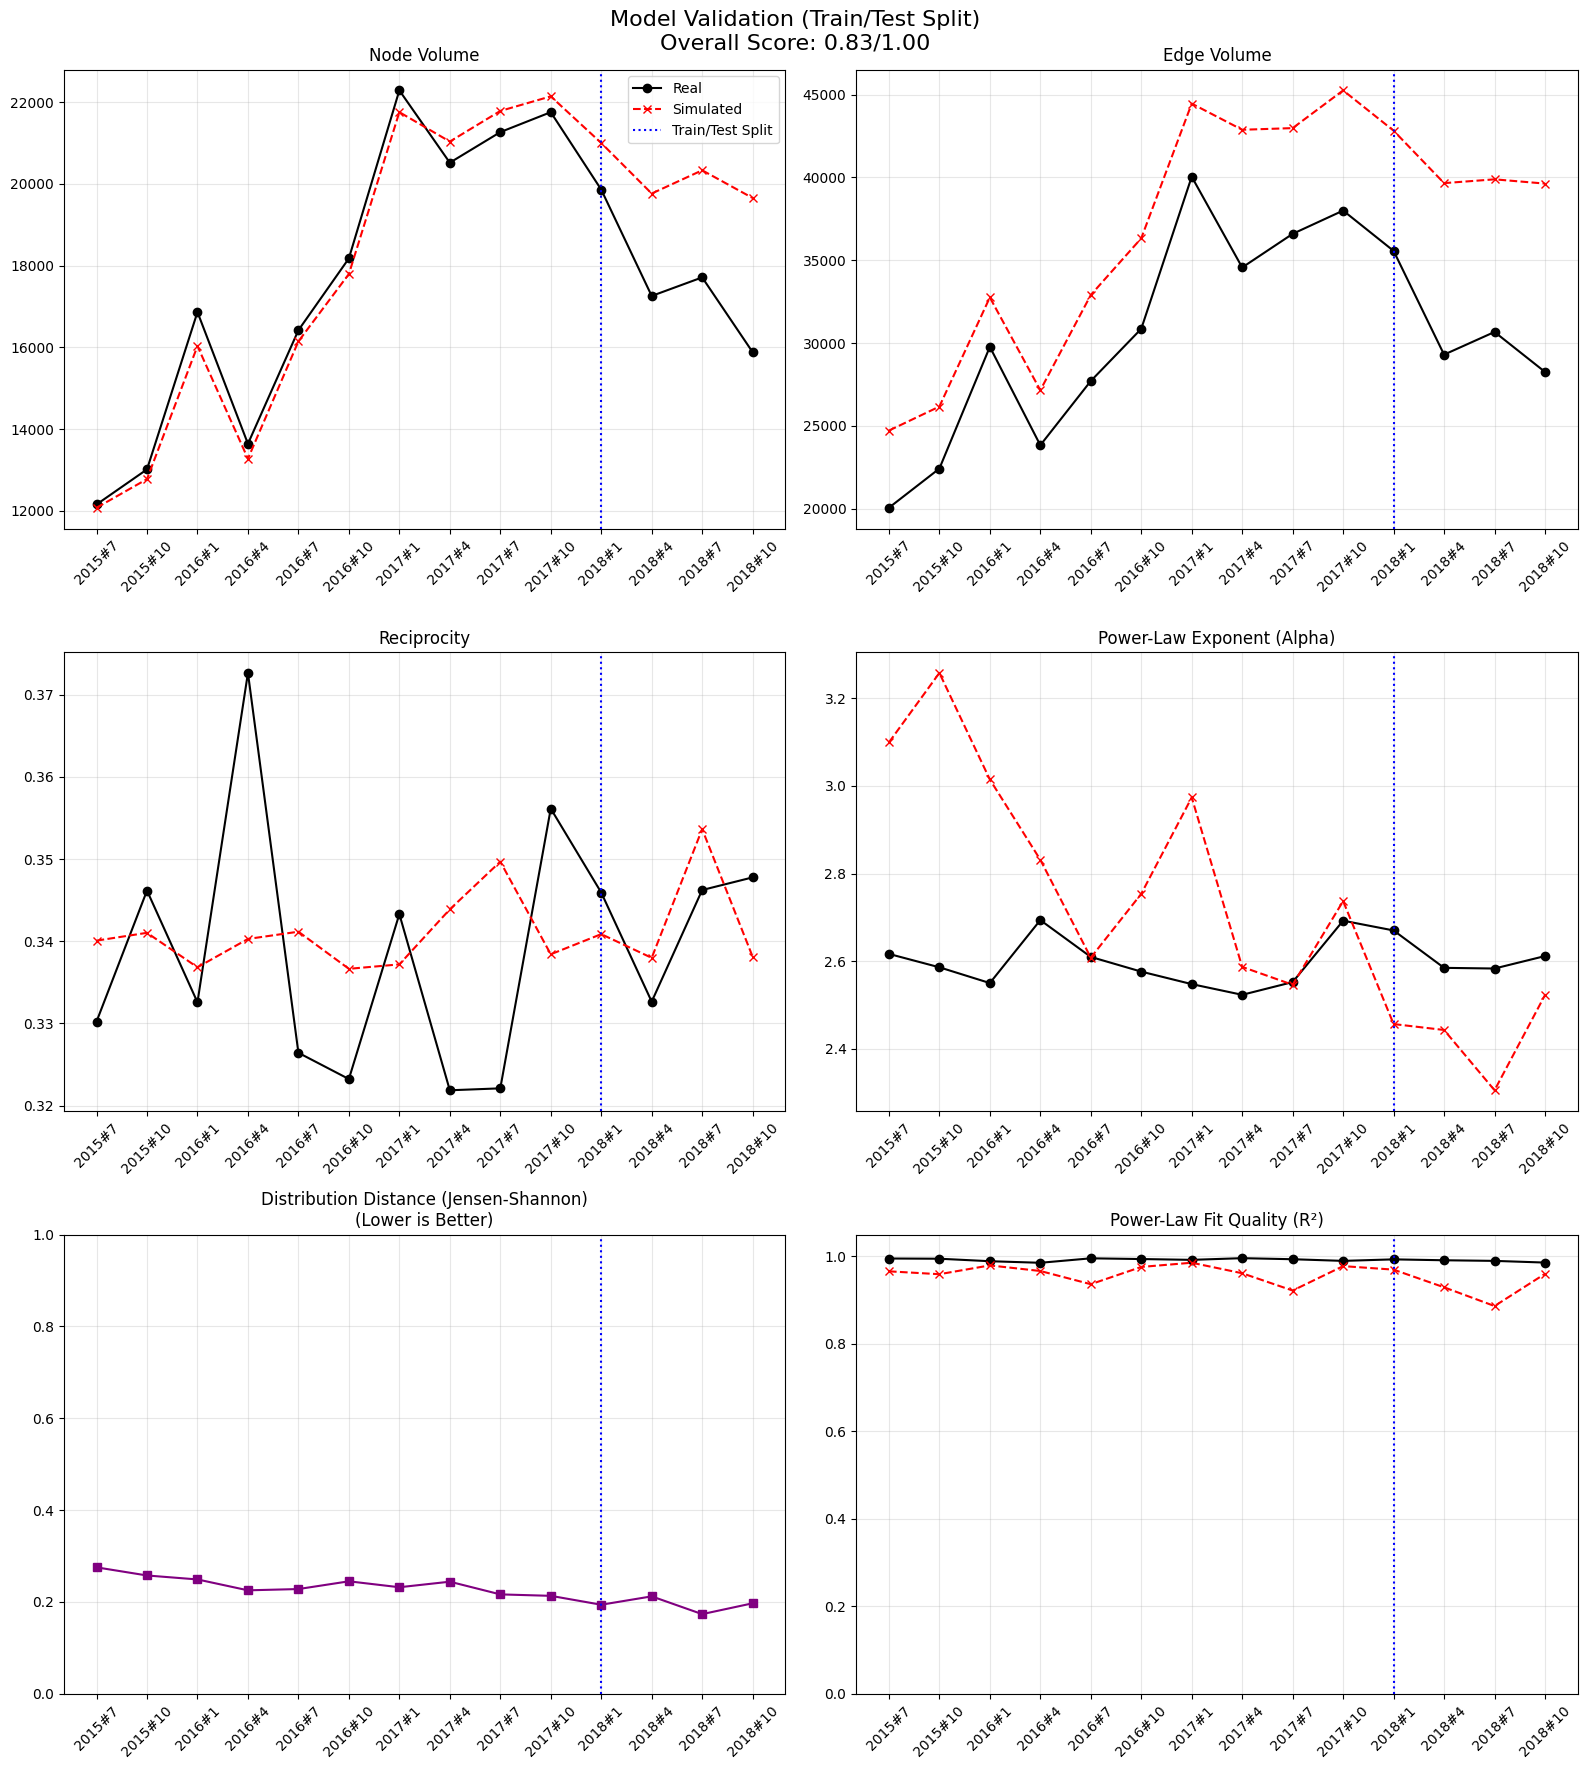


Validation Summary (Test Set Only):


,Time,Phase,Nodes_Real,Nodes_Sim,Edges_Real,Edges_Sim,Recip_Real,Recip_Sim,JS_Divergence,Alpha_Real,Alpha_Sim,R2_Real,R2_Sim,Err_Edges,Err_Recip,Composite_Error,Score
11,2018#4,Test,17256,19762,29298,39653,0.333,0.338,0.212,2.585,2.443,0.991,0.929,0.353,0.016,0.196,0.804
12,2018#7,Test,17710,20331,30667,39882,0.346,0.354,0.173,2.583,2.306,0.990,0.887,0.300,0.021,0.166,0.834
13,2018#10,Test,15880,19653,28254,39625,0.348,0.338,0.197,2.612,2.523,0.986,0.960,0.402,0.028,0.208,0.792


Test Set Score / 'Accuracy measure' (%): 81.0224 ± 2.1584


In [29]:
# ...existing code...
# --- 1. Train/Test Split ---
sorted_keys = sorted(snapshots.keys(), key=lambda x: (int(x.split('#')[0]), int(x.split('#')[1])))
split_idx = int(len(sorted_keys) * 0.8)
train_keys = sorted_keys[:split_idx]
test_keys = sorted_keys[split_idx:]

print(f"Training on {len(train_keys)} snapshots (2015-2017ish)")
print(f"Testing on {len(test_keys)} snapshots (2018ish)")

train_snapshots = {k: snapshots[k] for k in train_keys}

# --- 2. Parameter Estimation ---
# A. Learn structural parameters from Training Set ONLY
train_params = estimate_simulation_parameters(train_snapshots)

# B. Get birth rates for the WHOLE period (Exogenous input)
# In a real forecast, you'd project this, but here we use actual birth rates as input
all_params = estimate_simulation_parameters(snapshots)

# C. Merge: Use Train Physics + Full Timeline
simulation_params = all_params.copy()
simulation_params['P'] = train_params['P']
simulation_params['avg_reciprocity'] = train_params['avg_reciprocity']
simulation_params['avg_out_degree'] = train_params['avg_out_degree']

print(f"Learned Parameters (Train Set):")
print(f" - Reciprocity: {simulation_params['avg_reciprocity']:.3f}")
print(f" - Avg Out-Degree: {simulation_params['avg_out_degree']:.3f}")

# --- 3. Run Simulation ---
start_key = sorted_keys[0]
sim = RedditNetworkSimulator(snapshots[start_key], simulation_params)
simulated_snapshots = {}

print("Running simulation...")
for i in range(len(sorted_keys) - 1):
    G_t = sim.step()
    if G_t is None: break
    simulated_snapshots[i] = G_t

# --- 4. Advanced Validation Metrics ---

def calculate_js_divergence(G1, G2):
    # Get distributions
    d1 = [d for n, d in G1.degree()]
    d2 = [d for n, d in G2.degree()]

    if not d1 or not d2: return 1.0

    # Define common bins
    max_val = max(max(d1), max(d2))
    # Use logarithmic bins for scale-free networks
    bins = np.logspace(0, np.log10(max_val+1), 30)

    h1, _ = np.histogram(d1, bins=bins, density=True)
    h2, _ = np.histogram(d2, bins=bins, density=True)

    # Add small epsilon to avoid zero division/log issues
    h1 = h1 + 1e-10
    h2 = h2 + 1e-10

    return jensenshannon(h1, h2)

def fit_power_law(G):
    degrees = [d for n, d in G.degree() if d > 0]
    if len(degrees) < 10: return 0, 0

    # Fit on CCDF (Complementary Cumulative Distribution Function)
    # Log-Log Regression
    degrees = np.array(degrees)
    degrees.sort()

    # Calculate CCDF
    n = len(degrees)
    ccdf = np.arange(n, 0, -1) / n

    # Log-Log transform
    log_k = np.log10(degrees)
    log_P = np.log10(ccdf)

    # Remove duplicates to avoid steps in regression
    unique_k, indices = np.unique(log_k, return_index=True)
    unique_P = log_P[indices]

    if len(unique_k) < 5: return 0, 0

    slope, intercept, r_value, p_value, std_err = stats.linregress(unique_k, unique_P)

    # Alpha = 1 - slope (for PDF) or just slope for CCDF
    # Usually reported as positive alpha for P(k) ~ k^-alpha
    # Since CCDF slope is -(alpha-1), then alpha = 1 - slope
    return 1 - slope, r_value**2

comparison_data = []

for t, G_sim in simulated_snapshots.items():
    if t + 1 >= len(sorted_keys): break
    real_key = sorted_keys[t+1]
    G_real = snapshots[real_key]

    # Metrics
    n_real, n_sim = G_real.number_of_nodes(), G_sim.number_of_nodes()
    e_real, e_sim = G_real.number_of_edges(), G_sim.number_of_edges()
    r_real, r_sim = nx.reciprocity(G_real), nx.reciprocity(G_sim)

    # JS Divergence (Distribution Distance)
    js_div = calculate_js_divergence(G_real, G_sim)

    # Power Law Fit
    alpha_real, r2_real = fit_power_law(G_real)
    alpha_sim, r2_sim = fit_power_law(G_sim)

    # Phase (Train or Test)
    phase = 'Train' if real_key in train_keys else 'Test'

    comparison_data.append({
        'Time': real_key,
        'Phase': phase,
        'Nodes_Real': n_real, 'Nodes_Sim': n_sim,
        'Edges_Real': e_real, 'Edges_Sim': e_sim,
        'Recip_Real': r_real, 'Recip_Sim': r_sim,
        'JS_Divergence': js_div,
        'Alpha_Real': alpha_real, 'Alpha_Sim': alpha_sim,
        'R2_Real': r2_real, 'R2_Sim': r2_sim
    })

df_comp = pd.DataFrame(comparison_data)

# --- 5. Composite Score ---
# Score = 1 - Mean(Normalized Absolute Error)
# We'll weight metrics: Edges (0.3), Reciprocity (0.3), JS_Div (0.4)

df_comp['Err_Edges'] = abs(df_comp['Edges_Real'] - df_comp['Edges_Sim']) / df_comp['Edges_Real']
df_comp['Err_Recip'] = abs(df_comp['Recip_Real'] - df_comp['Recip_Sim']) / df_comp['Recip_Real']
# JS is already an error metric (0=identical, 1=disjoint)

df_comp['Composite_Error'] = (0.3 * df_comp['Err_Edges']) + (0.3 * df_comp['Err_Recip']) + (0.4 * df_comp['JS_Divergence'])
df_comp['Score'] = 1 - df_comp['Composite_Error']
# Clip score to 0-1
df_comp['Score'] = df_comp['Score'].clip(0, 1)

# --- Visualization ---
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle(f'Model Validation (Train/Test Split)\nOverall Score: {df_comp["Score"].mean():.2f}/1.00', fontsize=16)

# 1. Nodes
axes[0,0].plot(df_comp['Time'], df_comp['Nodes_Real'], 'o-', label='Real', color='black')
axes[0,0].plot(df_comp['Time'], df_comp['Nodes_Sim'], 'x--', label='Simulated', color='red')
if train_keys:
    axes[0,0].axvline(x=train_keys[-1], color='blue', linestyle=':', label='Train/Test Split')
axes[0,0].set_title('Node Volume')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. Edges
axes[0,1].plot(df_comp['Time'], df_comp['Edges_Real'], 'o-', label='Real', color='black')
axes[0,1].plot(df_comp['Time'], df_comp['Edges_Sim'], 'x--', label='Simulated', color='red')
if train_keys:
    axes[0,1].axvline(x=train_keys[-1], color='blue', linestyle=':', label='Train/Test Split')
axes[0,1].set_title('Edge Volume')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Reciprocity
axes[1,0].plot(df_comp['Time'], df_comp['Recip_Real'], 'o-', label='Real', color='black')
axes[1,0].plot(df_comp['Time'], df_comp['Recip_Sim'], 'x--', label='Simulated', color='red')
if train_keys:
    axes[1,0].axvline(x=train_keys[-1], color='blue', linestyle=':', label='Train/Test Split')
axes[1,0].set_title('Reciprocity')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Power Law Alpha
axes[1,1].plot(df_comp['Time'], df_comp['Alpha_Real'], 'o-', label='Real', color='black')
axes[1,1].plot(df_comp['Time'], df_comp['Alpha_Sim'], 'x--', label='Simulated', color='red')
if train_keys:
    axes[1,1].axvline(x=train_keys[-1], color='blue', linestyle=':', label='Train/Test Split')
axes[1,1].set_title('Power-Law Exponent (Alpha)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# 5. JS Divergence
axes[2,0].plot(df_comp['Time'], df_comp['JS_Divergence'], 's-', color='purple', label='JS Divergence')
if train_keys:
    axes[2,0].axvline(x=train_keys[-1], color='blue', linestyle=':', label='Train/Test Split')
axes[2,0].set_title('Distribution Distance (Jensen-Shannon)\n(Lower is Better)')
axes[2,0].set_ylim(0, 1)
axes[2,0].tick_params(axis='x', rotation=45)
axes[2,0].grid(True, alpha=0.3)

# 6. Power Law R2
axes[2,1].plot(df_comp['Time'], df_comp['R2_Real'], 'o-', label='Real', color='black')
axes[2,1].plot(df_comp['Time'], df_comp['R2_Sim'], 'x--', label='Simulated', color='red')
if train_keys:
    axes[2,1].axvline(x=train_keys[-1], color='blue', linestyle=':', label='Train/Test Split')
axes[2,1].set_title('Power-Law Fit Quality (R²)')
axes[2,1].set_ylim(0, 1.05)
axes[2,1].tick_params(axis='x', rotation=45)
axes[2,1].grid(True, alpha=0.3)

plt.tight_layout()

# Save outputs
output_dir = Path("../data/04_reports/evolution_sims/")
output_dir.mkdir(parents=True, exist_ok=True)

csv_path = output_dir / "validation_metrics.csv"
df_comp.to_csv(csv_path, index=False)
print(f"Metrics saved to {csv_path}")

plot_path = output_dir / "validation_plots.png"
plt.savefig(plot_path)
print(f"Plot saved to {plot_path}")

plt.show()

print("\nValidation Summary (Test Set Only):")
test_df = df_comp[df_comp['Phase'] == 'Test']
display(test_df.round(3))

score_mean = test_df['Score'].mean()*100
score_std = test_df['Score'].std()*100
if not test_df.empty:
    print(f"Test Set Score / 'Accuracy measure' (%): {score_mean:.4f} ± {score_std:.4f}")